In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras 
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [125]:
def readTextfile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [126]:
captions = readTextfile("captions.txt")
print(len(captions.split("\n")))

40457


In [127]:
captions = captions.split("\n")[1:-1]

In [128]:
captions[0]

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .'

In [129]:
captions[-1]

'997722733_0cb5439472.jpg,A rock climber practices on a rock climbing wall .'

In [130]:
print(len(captions))

40455


In [131]:
#Dict to map each image with the list of captions it has

In [132]:
sen = captions[0]
print(sen.split(","))
sen = sen.split(",")

['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .']


In [133]:
print(sen)

['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .']


In [134]:
import cv2

./Images/1000268201_693b08cb0e.jpg


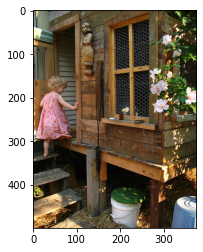

(500, 375, 3)


In [135]:
path = "./Images/"+sen[0]
print(path)
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
print(img.shape)

In [136]:
descriptions = {}
cnt = 0
for x in captions:
    sen = x.split(",")
    if descriptions.get(sen[0]) is None:
        descriptions[sen[0]] = []
    descriptions[sen[0]].append(sen[1])

In [137]:
descriptions["1000268201_693b08cb0e.jpg"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [138]:
#Data Cleaning

In [139]:
import re #A regular Expression Function

In [140]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence

In [141]:
clean_text("A Cat is sitting on house #34")

'cat is sitting on house'

In [142]:
#Clean all Captions

In [143]:
for key, captions_list in descriptions.items():
    for i in range(len(captions_list)):
        captions_list[i] = clean_text(captions_list[i])

In [144]:
descriptions["1000268201_693b08cb0e.jpg"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [145]:
#write data in a text file

In [146]:
with open("descriptions.txt", "w") as f:
    f.write(str(descriptions))

In [147]:
#Vocab

In [148]:
import json #Convert str to dict

In [149]:
descriptions = None
with open("descriptions.txt", "r") as f:
    descriptions = f.read()
    json_acceptable_string = descriptions.replace("'", "\"")
    descriptions = json.loads(json_acceptable_string)

In [150]:
descriptions["1000268201_693b08cb0e.jpg"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [151]:
vocab = set()
for key in descriptions.keys():
    [vocab.update( sentence.split() ) for sentence in descriptions[key]]
print(len(vocab))

8257


In [152]:
#Total words across all the sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print(len(total_words))

357791


In [153]:
#Filter words from vocab according to certain threshold frequency

In [154]:
import collections
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8257


In [155]:
#Sort according to frequncy count

In [156]:
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key = lambda x: x[1])
#Filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1] > threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [157]:
print(len(total_words))

1800


In [158]:
#Prepare test train data

In [159]:
import random

In [160]:
total_imgs_id = [key for key in descriptions.keys()]
random.shuffle(total_imgs_id)
train_imgs_id = total_imgs_id[:6000]
test_imgs_id = total_imgs_id[6000:]

In [161]:
print(len(total_imgs_id))
print(len(train_imgs_id))
print(len(test_imgs_id))

8091
6000
2091


In [162]:
train = train_imgs_id
test = test_imgs_id

In [163]:
#Prepare description for training data
#Add <s> and <e> tokens in training data

In [164]:
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_add = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_add)

In [165]:
train_descriptions["1000268201_693b08cb0e.jpg"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [166]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [167]:
model_new = Model(model.input, model.layers[-2].output)

In [168]:
def preprocess_img(img):
    img = image.load_img(img, target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    #Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


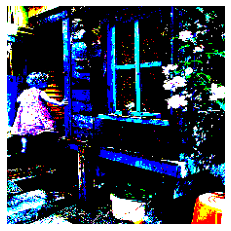

151.061
-123.68


In [169]:
img = preprocess_img("./Images/" + "1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()
print(np.max(img))
print(np.min(img))

In [170]:
def encode_img(img):
    #Preprocess Img and then pass it through ResNet50
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((2048,))
#     print(feature_vector.shape)
    return feature_vector
    

In [171]:
encode_img("./Images/" + "1000268201_693b08cb0e.jpg")

array([0.04154462, 0.17075884, 0.2927681 , ..., 0.05094037, 0.31319624,
       0.8600727 ], dtype=float32)

In [173]:
encoding_train = {} #map img id to its feature vector
start_t = time()
for ix, img_id in enumerate(train):
    img_path = "./Images/" + img_id
    encoding_train[img_id] = encode_img(img_path)
    if ix%100 == 0:
        print("Encdoing in progress time step %d"%ix)
end_t = time()
print("total time taken: ",end_t - start_t)

In [135]:
#Store on disk
encoding_train["3441145615_b4fcd9eea0.jpg"].shape

(2048,)

In [136]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train, f)
    

In [138]:
print(len(test))

2091


In [139]:
encoding_test = {} #map img id to its feature vector
start_t = time()
for ix, img_id in enumerate(test):
    img_path = "./Images/" + img_id
    encoding_test[img_id] = encode_img(img_path)
    if ix%100 == 0:
        print("Test Encdoing in progress time step %d"%ix)
end_t = time()
print("total time taken: ",end_t - start_t)

Test Encdoing in progress time step 0
Test Encdoing in progress time step 100
Test Encdoing in progress time step 200
Test Encdoing in progress time step 300
Test Encdoing in progress time step 400
Test Encdoing in progress time step 500
Test Encdoing in progress time step 600
Test Encdoing in progress time step 700
Test Encdoing in progress time step 800
Test Encdoing in progress time step 900
Test Encdoing in progress time step 1000
Test Encdoing in progress time step 1100
Test Encdoing in progress time step 1200
Test Encdoing in progress time step 1300
Test Encdoing in progress time step 1400
Test Encdoing in progress time step 1500
Test Encdoing in progress time step 1600
Test Encdoing in progress time step 1700
Test Encdoing in progress time step 1800
Test Encdoing in progress time step 1900
Test Encdoing in progress time step 2000
total time taken:  915.9010455608368


In [140]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test, f)
    

In [56]:
#Data processing for captions

In [174]:
#Vocab
len(total_words)

1800

In [175]:
word_to_idx = {}
idx_to_word = {}
for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
    

In [176]:
print(word_to_idx["dog"])
print(idx_to_word[6])

6
dog


In [177]:
idx_to_word[1800]

'cannon'

In [178]:
#add startseq and endseq in the dict
idx_to_word[1801] = "startseq"
word_to_idx["startseq"] = 1801

idx_to_word[1802] = "endseq"
word_to_idx["endseq"] = 1802

In [179]:
print(len(word_to_idx))

1802


In [180]:
vocab_size = len(word_to_idx) + 1 #add 1 as 0 is assigned to neglect

In [181]:
print(vocab_size)

1803


In [182]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
print(max_len)

31


In [183]:
max_len = 35

In [184]:
print(len(train_descriptions))

6000


In [185]:
encoding_train = pd.read_pickle("./encoded_train_features.pkl")
encoding_test = pd.read_pickle("./encoded_test_features.pkl")

In [186]:
print(len(encoding_train))
print(len(encoding_test))
print(len(train_descriptions))

6000
2091
6000


In [208]:
print(type(encoding_train))

<class 'dict'>


In [206]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    X1, X2, y = [],[],[]
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            photo = encoding_train[key]
            for cap in desc_list:
                seq = [word_to_idx[word] for word in cap.split() if word in word_to_idx.keys()]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    xi = pad_sequences([xi], maxlen = max_len, value = 0, padding="post")[0] # pad_sequences accepts 2d matrix
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    #we get one training pt. xi, yi
                    X1.append(photo)
                    X2.append(xi) #later convert into glove embedding
                    y.append(yi) #word that want, size of vocab size 
            if n==batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y)) #Yield in used in generator functions that remember the previous values
                X1, X2, y = [], [], []
                n = 0
                

In [188]:
#word embeddings using glove vector

In [189]:
f = open("glove.6B.50D.txt", encoding = "utf-8")    

In [190]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    embedding_word = np.array(values[1:], dtype = "float")
    embedding_index[word] = embedding_word

In [191]:
f.close()

In [192]:
print(embedding_index["apple"])

[ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]


In [193]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix
        

In [194]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1803, 50)


In [195]:
embedding_matrix[1801]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [196]:
#Model Architecture

In [197]:
input_img_features = Input(shape = (2048,))
inp_img_1 = Dropout(0.3)(input_img_features)
inp_img_2 = Dense(256, activation = "relu")(inp_img_1)

In [198]:
#Captions as input
input_captions = Input(shape = (max_len,))
inp_cap_1 = Embedding(input_dim = vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap_2 = Dropout(0.3)(inp_cap_1)
inp_cap_3 = LSTM(256)(inp_cap_2)

In [199]:
decoder1 = add(inputs=[inp_img_2, inp_cap_3])
decoder2 = Dense(256, activation = "relu")(decoder1)
outputs = Dense(vocab_size, activation = "softmax")(decoder2)

In [200]:
model = Model(inputs = [input_img_features, input_captions], outputs = outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 50)       90150       input_8[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_7[0][0]                    
__________________________________________________________________________________________________
dropout_6 

In [201]:
#Initialize embedding matrix
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [202]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam")

In [203]:
total_epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size
print(steps)

2000


In [209]:
def train():
    for i in range(total_epochs):
        generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
        model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
        generator.save("./model_weights/model_"+str(i)+".h5")

In [212]:
train()

In [213]:
model = load_model("./model_weights/model_9.h5")

In [214]:
def predict_captions(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen = max_len, padding = "post")
        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax() #Word with max probability (Greedy Sampling)
        word = idx_to_word[ypred]
        in_text += " " + word
        
        if word == "endseq":
            break
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [220]:
#Pick some random images to test results
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    caption = predict_captions(photo_2048)
    i = plt.imread("./Images/" + img_name)
    plt.figure(0, figsize = (5,5))
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    print(caption)